In [1]:
!wget https://www.proteinatlas.org/download/proteinatlas.xml.gz 

--2018-12-21 18:20:04--  https://www.proteinatlas.org/download/proteinatlas.xml.gz
Resolving www.proteinatlas.org (www.proteinatlas.org)... 130.237.79.41
Connecting to www.proteinatlas.org (www.proteinatlas.org)|130.237.79.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 274541144 (262M) [application/x-gzip]
Saving to: ‘proteinatlas.xml.gz’

proteinatlas.xml.gz 100%[===================>] 261.82M  2.80MB/s    in 98s     

2018-12-21 18:21:43 (2.69 MB/s) - ‘proteinatlas.xml.gz’ saved [274541144/274541144]



In [2]:
!gzip -d ./proteinatlas.xml.gz

In [3]:
import xml.etree.ElementTree as etree
import matplotlib.pyplot as plt
import pandas as pd

from skimage import io
from tqdm import tqdm_notebook as tqdm
from collections import defaultdict

PROTEINATLAS_XML_PATH = "./proteinatlas.xml"
TRAIN_EXTRA_PATH = "train_extra.csv"

counter = 0
pbar = tqdm(total=70328)
data = []
other_labels = defaultdict(int)

# There are more labels in the extra training data than there are in the official training data
name_to_label_dict = {'nucleoplasm': 0, 'nuclear membrane': 1, 'nucleoli': 2, 'nucleoli fibrillar center': 3,
                      'nuclear speckles': 4, 'nuclear bodies': 5, 'endoplasmic reticulum': 6, 'golgi apparatus': 7,
                      'peroxisomes': 8, 'endosomes': 9, 'lysosomes': 10, 'intermediate filaments': 11,
                      'actin filaments': 12, 'focal adhesion sites': 13, 'microtubules': 14, 'microtubule ends': 15,
                      'cytokinetic bridge': 16, 'mitotic spindle': 17, 'microtubule organizing center': 18,
                      'centrosome': 19, 'lipid droplets': 20, 'plasma membrane': 21, 'cell junctions': 22,
                      'mitochondria': 23, 'aggresome': 24, 'cytosol': 25, 'cytoplasmic bodies': 26,
                      'rods & rings': 27, 'midbody': [16, 12], 'midbody ring': [16, 12], 'cleavage furrow': 16, 'vesicles': [8, 9, 10, 20]}

# Iterate over the XML file (since parsing it in one run might blow up the memory)
for event, elem in etree.iterparse(PROTEINATLAS_XML_PATH, events=('start', 'end', 'start-ns', 'end-ns')):
    if event == 'start':
        if elem.tag == "data" and len({"location", "assayImage"} - set([c.tag for c in elem.getchildren()])) == 0:
            labels = []
            assay_image = None
            for c in elem.getchildren():
                if c.tag == 'assayImage':
                    assay_image = c
                if c.tag == 'location':
                    if c.text in name_to_label_dict:
                        label = name_to_label_dict[c.text]
                        if type(label) is int:
                           labels.append(label)
                        else:
                            for l in label:
                                labels.append(l)
                    else:
                        other_labels[c.text] += 1
            if not labels:
                # Let's ignore images that do not have labels
                continue
            for image in assay_image.getchildren():
                if len(image.getchildren()) < 4 or image.getchildren()[-1].text is None:
                    continue
                image_url = image.getchildren()[-1].text
                assert "blue_red_green" in image_url
                for channel, color, object_ in zip(image.getchildren()[:-1], ["blue", "red", "green"], ["nucleus", "microtubules", "antibody"]):
                    assert channel.text == object_
                    assert channel.attrib["color"] == color

                # "https://v18.proteinatlas.org/images/4109/24_H11_1_blue_red_green_yellow.jpg" -> "4109/24_H11_1"
                data.append(["/".join(image_url.split("/")[-2:]).replace("_blue_red_green.jpg", ""), " ".join(str(x) for x in sorted(labels, reverse=True))])
                counter += 1
                pbar.update()
        # This is necessary to free up memory
        elem.clear()
print(counter)
# Samples are also labeled with 'nucleus', which can not be translated into official labels
print(other_labels)

df = pd.DataFrame(data=data, columns=["Id", "Target"])
df.to_csv(TRAIN_EXTRA_PATH, index=False)

70327
defaultdict(<class 'int'>, {'nucleus': 4547})


In [4]:
df.head()

,Id,Target
0,4109/24_H11_1,25
1,4109/24_H11_2,25
2,4109/23_H11_1,25
3,4109/23_H11_2,25
4,4109/25_H11_1,25


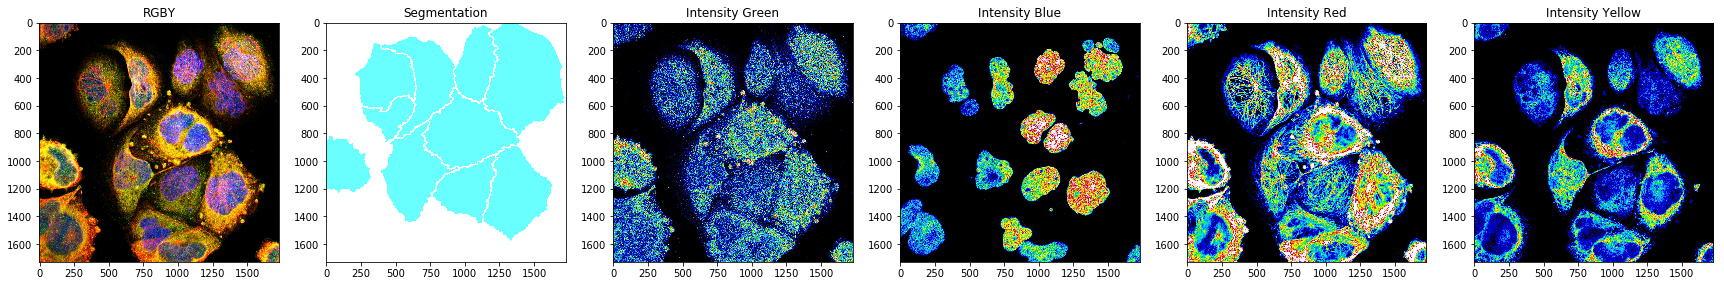

In [14]:
hpa_base = "https://v18.proteinatlas.org/images"
titles = ["RGBY", "Segmentation", "Intensity Green", "Intensity Blue", "Intensity Red", "Intensity Yellow"]
urls = ["/{}_blue_red_green_yellow.jpg", "_cell_segmentation/{}_segmentation.png", "/{}_green_lut.jpg", "/{}_blue_lut.jpg", "/{}_red_lut.jpg", "/{}_yellow_lut.jpg"]
_, axes = plt.subplots(nrows=1, ncols=len(urls), figsize=(5 * len(urls), 5))
for index, (title, url) in enumerate(zip(titles, urls)):
    image = io.imread(hpa_base + url.format(df.loc[1, "Id"]))
    axes[index].imshow(image)
    axes[index].set_title(title)

Text(0.5,1,'RGBY')

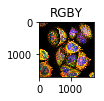

In [24]:
hpa_base = "https://v18.proteinatlas.org/images"
titles = ["RGBY"]
urls = ["/{}_blue_red_green_yellow.jpg"]
# _, axes = plt.subplots(nrows=1, ncols=len(urls), figsize=(len(urls), 1))

# image = io.imread(hpa_base + url.format(df.loc[1, "Id"]))
# axes.imshow(image)
# axes.set_title(title)

In [27]:
hpa_base = "https://v18.proteinatlas.org/images"
titles = ["RGBY"]
urls = ["/{}_blue_red_green_yellow.jpg"]
with open('url.txt','w') as f:
    for i in range(70327):
        f.write(hpa_base+url.format(df.loc[i, "Id"])+'\n')